In [1]:
# Read a single wind swath from ASCAT-B surface wind data and the corresponding MUR SST to show that we find a 
# surface slow down of the wind speed over the cold patch.

In [2]:
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import glob
import datetime as dt
import gzip
import cdsapi
import tarfile
import h5netcdf
from numpy import random
from scipy.interpolate import griddata, interp1d
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.ndimage import correlate

In [3]:
def L2wind_2_regular_grid_mask(lon_wind,lat_wind,u,v,lon_sst,lat_sst,extent_param):
    """
    Function to interpolate the wind from the scatterometer to the SST grid using a linear approach 
    separating the two halves of the scatterometer observation. It also discard conditions when less than 4 points
    are to be interpolated (which is impossible with the griddata function). It avoids the fake interpolated data
    generated by griddata within the convex hull of the set of points creating a mask using the original lon lat of 
    the wind data.
    """
    import numpy as np
    from scipy.interpolate import griddata, interp1d
    from scipy.ndimage import correlate

    swath_width = np.size(u,1) # The 0-th axis is the length of the swath.
    mid = int(np.round(swath_width/2))

    lon1_wind = lon_wind[:,:mid]
    lon2_wind = lon_wind[:,mid:]
    lat1_wind = lat_wind[:,:mid]
    lat2_wind = lat_wind[:,mid:]

    lon1_area = lon1_wind[(lon_wind[:,:mid]>extent_param[0]) & (lon_wind[:,:mid]<extent_param[1]) & 
                          (lat_wind[:,:mid]>extent_param[2]) & (lat_wind[:,:mid]<extent_param[3])]
    lon2_area = lon2_wind[(lon_wind[:,mid:]>extent_param[0]) & (lon_wind[:,mid:]<extent_param[1]) & 
                          (lat_wind[:,mid:]>extent_param[2]) & (lat_wind[:,mid:]<extent_param[3])]
    lat1_area = lat1_wind[(lon_wind[:,:mid]>extent_param[0]) & (lon_wind[:,:mid]<extent_param[1]) & 
                          (lat_wind[:,:mid]>extent_param[2]) & (lat_wind[:,:mid]<extent_param[3])]
    lat2_area = lat2_wind[(lon_wind[:,mid:]>extent_param[0]) & (lon_wind[:,mid:]<extent_param[1]) & 
                          (lat_wind[:,mid:]>extent_param[2]) & (lat_wind[:,mid:]<extent_param[3])]

    u1 = u[:,:mid]
    u2 = u[:,mid:]

    u1_area = u1[(lon_wind[:,:mid]>extent_param[0]) & (lon_wind[:,:mid]<extent_param[1]) & 
                 (lat_wind[:,:mid]>extent_param[2]) & (lat_wind[:,:mid]<extent_param[3])]
    u2_area = u2[(lon_wind[:,mid:]>extent_param[0]) & (lon_wind[:,mid:]<extent_param[1]) & 
                 (lat_wind[:,mid:]>extent_param[2]) & (lat_wind[:,mid:]<extent_param[3])]

    llon, llat = np.meshgrid(lon_sst,lat_sst)

    if (np.isnan(u1_area).all()) and (np.isnan(u2_area).all()):
        u_interp = np.nan
    elif (len(u1_area)<4) and (len(u2_area)<4): # In this case no interpolation can be performed.
        u_interp = np.nan
    else:
        if (np.isnan(u2_area).all()) or (len(u2_area)<4):
            u_interp = griddata((lon1_area,lat1_area),u1_area,(llon,llat))
            # Remove the fake points within the convex hull using a mask.
            f_upper = interp1d(lon1_wind[:,-1],lat1_wind[:,-1],kind='linear',fill_value='extrapolate')
            f_lower = interp1d(lon1_wind[:,0],lat1_wind[:,0],kind='linear',fill_value='extrapolate')
            valid_mask = (llat<f_upper(lon_sst)) & (llat>f_lower(lon_sst))
            u_interp[~valid_mask] = np.nan
        elif (np.isnan(u1_area).all()) or (len(u1_area)<4):
            u_interp = griddata((lon2_area,lat2_area),u2_area,(llon,llat))
            # Remove the fake points within the convex hull.
            f_upper = interp1d(lon2_wind[:,-1],lat2_wind[:,-1],kind='linear',fill_value='extrapolate')
            f_lower = interp1d(lon2_wind[:,0],lat2_wind[:,0],kind='linear',fill_value='extrapolate')
            valid_mask = (llat<f_upper(lon_sst)) & (llat>f_lower(lon_sst))
            u_interp[~valid_mask] = np.nan
        else:
            u1_interp = griddata((lon1_area,lat1_area),u1_area,(llon,llat))
            # Remove the fake points within the convex hull.
            f1_upper = interp1d(lon1_wind[:,-1],lat1_wind[:,-1],kind='linear',fill_value='extrapolate')
            f1_lower = interp1d(lon1_wind[:,0],lat1_wind[:,0],kind='linear',fill_value='extrapolate')
            valid_mask1 = (llat<f1_upper(lon_sst)) & (llat>f1_lower(lon_sst))
            u1_interp[~valid_mask1] = np.nan

            u2_interp = griddata((lon2_area,lat2_area),u2_area,(llon,llat))
            # Remove the fake points within the convex hull.
            f2_upper = interp1d(lon2_wind[:,-1],lat2_wind[:,-1],kind='linear',fill_value='extrapolate')
            f2_lower = interp1d(lon2_wind[:,0],lat2_wind[:,0],kind='linear',fill_value='extrapolate')
            valid_mask2 = (llat<f2_upper(lon_sst)) & (llat>f2_lower(lon_sst))
            u2_interp[~valid_mask2] = np.nan

            u_interp = u1_interp; np.putmask(u_interp,~np.isnan(u2_interp),u2_interp)            
        # At the edge of the swath there might be some discontinuities: remove them by setting those
        # points to NaN (2 points are removed). We do this with a squared filter on the NaN mask of the 
        # original swath.
        if ~np.isnan(u_interp).all():
            first_mask_nan = u_interp/u_interp
            footprint = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
            mask_nan = correlate(first_mask_nan,footprint/25)
            u_interp = u_interp*mask_nan
        # Alternatively, we can try to remove one grid point from the side of the mid when we select the u1 and u2
        # subfields. But this is not enough.  Even if I remove 1 point from both sides, some edge effect remains.

        
    u1 = v[:,:mid]
    u2 = v[:,mid:]

    u1_area = u1[(lon_wind[:,:mid]>extent_param[0]) & (lon_wind[:,:mid]<extent_param[1]) & 
                 (lat_wind[:,:mid]>extent_param[2]) & (lat_wind[:,:mid]<extent_param[3])]
    u2_area = u2[(lon_wind[:,mid:]>extent_param[0]) & (lon_wind[:,mid:]<extent_param[1]) & 
                 (lat_wind[:,mid:]>extent_param[2]) & (lat_wind[:,mid:]<extent_param[3])]

    if (np.isnan(u1_area).all()) and (np.isnan(u2_area).all()):
        v_interp = np.nan
    elif (len(u1_area)<4) and (len(u2_area)<4): # In this case no interpolation can be performed.
        v_interp = np.nan
    else:
        if (np.isnan(u2_area).all()) or (len(u2_area)<4):
            v_interp = griddata((lon1_area,lat1_area),u1_area,(llon,llat))
            v_interp[~valid_mask] = np.nan
        elif (np.isnan(u1_area).all()) or (len(u1_area)<4):
            v_interp = griddata((lon2_area,lat2_area),u2_area,(llon,llat))
            v_interp[~valid_mask] = np.nan
        else:
            u1_interp = griddata((lon1_area,lat1_area),u1_area,(llon,llat))
            u1_interp[~valid_mask1] = np.nan

            u2_interp = griddata((lon2_area,lat2_area),u2_area,(llon,llat))
            u2_interp[~valid_mask2] = np.nan

            v_interp = u1_interp; np.putmask(v_interp,~np.isnan(u2_interp),u2_interp)            
        # At the edge of the swath there might be some discontinuities: remove them by setting those
        # points to NaN (2 points are removed). We do this with a squared filter on the NaN mask of the 
        # original swath.
        if ~np.isnan(v_interp).all():
            first_mask_nan = v_interp/v_interp
            footprint = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
            mask_nan = correlate(first_mask_nan,footprint/25)
            v_interp = v_interp*mask_nan
        # Alternatively, we can try to remove one grid point from the side of the mid when we select the u1 and u2
        # subfields. But this is not enough.  Even if I remove 1 point from both sides, some edge effect remains.
            
    return u_interp, v_interp

In [43]:
def metrics_fixed_bin_distribution(control, variable, perc_step=5):
    """
    Function to compute the slope of the linear regression based on the fixed bin distribution of the input variables.
    It also computes the intercept, the spearman r and its p-value.
    At this stage the slope does not consider the standard error of the mean value for each percentile.
    """
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt

    mean = np.nanmean(variable)
    mean_control = np.nanmean(control)
    std = np.nanstd(variable)
    std_control = np.nanstd(control)

    nbins = int(100/perc_step)
    bw = (np.max(control[~np.isnan(control)])-np.min(control[~np.isnan(control)]))/nbins # Bin width.
    distribution_fb = np.zeros(nbins)
    std_distribution_fb = np.zeros(nbins)
    std_err_distribution_fb = np.zeros(nbins)
    distribution_control_fb = np.zeros(nbins)
    number_of_points_fb = np.zeros(nbins)
    bin_edges_fb = np.zeros(nbins+1)

    for pp in range(0,100,perc_step):
        qq = int(pp/perc_step) # Index starting from 0.
        lower = np.min(control[~np.isnan(control)])+qq*bw
        upper = lower + bw
        bin_edges_fb[qq] = lower
        distribution_fb[qq] = np.nanmean(variable[(control>=lower)&(control<upper)])
        std_distribution_fb[qq] = np.nanstd(variable[(control>=lower)&(control<upper)])
        distribution_control_fb[qq] = np.nanmean(control[(control>=lower)&(control<upper)])
        number_of_points_fb[qq] = np.sum(~np.isnan(variable[(control>=lower)&(control<upper)]))
        std_err_distribution_fb[qq] = std_distribution_fb[qq]/np.sqrt(number_of_points_fb[qq])

    bin_edges_fb[-1] = upper
    bin_centers_fb = 0.5*(bin_edges_fb[1:]+bin_edges_fb[:-1])

    # Calculate the spearman r.
    sr_distr, trash = stats.spearmanr(distribution_control_fb,distribution_fb)
    df = len(distribution_control_fb)-2 # degrees of freedom.
    t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
    p_value = 1 - stats.t.cdf(t_value,df=df)

    # Perform the linear regression.
    mask = (~np.isnan(distribution_control_fb))&(~np.isnan(distribution_fb))&(~np.isnan(std_distribution_fb))
    distribution_control_fb, distribution_fb, std_distribution_fb = distribution_control_fb[mask], distribution_fb[mask], std_distribution_fb[mask]
    lsq_res = stats.linregress(distribution_control_fb, distribution_fb)
    slope = lsq_res[0]
    intercept = lsq_res[1]
    rvalue = lsq_res[2]
    p_slope = lsq_res[3]

    return slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope


In [4]:
# Set some relevant paths.
path2CCI_CDR = '/media/agostino/sailboat/'
path2wind = path2CCI_CDR + 'podaac/OceanWinds/'#'/mnt/podaac_drive/OceanWinds/'
path2ascat = path2wind + 'ascat/preview/L2/metop_b/coastal_opt/'
# Here we use Metop-B data at 12.5 km grid spacing.
path2MURSST = '/share/eureca_data/Satellites/MUR/'

In [5]:
# Set the geographical parameters for the figures.

#area_str = 'extended_eureca'; area_name = 'extended EUREC4A'
minlon = -55.5; maxlon = -52.; minlat = 5.5; maxlat = 8.5; 
sst_vmin = 26.; sst_vmax = 28.

extent_param = [minlon, maxlon, minlat, maxlat]

crs = ccrs.PlateCarree()    
def plot_background(ax):
    ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [6]:
# Set the day of interest.
year_oi = '2020'
month_oi = '02'
day_oi = '06'

date_sst_map = year_oi + '-' + month_oi + '-' + day_oi

In [7]:
# Read the MUR SST data.
filename_mur = path2MURSST + 'SST_MUR_' + date_sst_map + '.nc'
filename_mur_grid = path2MURSST + 'SST_MUR_Grid.nc'

ds_mur = xr.open_dataset(filename_mur)
ds_mur.close()
ds_mur_grid = xr.open_dataset(filename_mur_grid)
ds_mur_grid.close()

sst_mur = ds_mur['sst_MUR'].values
sst_mur_lon = ds_mur_grid['X_SST_MUR'].values
sst_mur_lat = ds_mur_grid['Y_SST_MUR'].values
lon_sst, lat_sst = np.meshgrid(sst_mur_lon,sst_mur_lat)
print(lat_sst.shape)

(1601, 1501)


In [8]:
# Read all the wind speed swaths in one day over the same area of interest, and select the time frame of interest.
doy = dt.datetime(int(year_oi), int(month_oi), int(day_oi)).timetuple().tm_yday
doy_str = str(doy).zfill(3) # 3 digits string.
path_wind_oi = path2ascat + '/' + year_oi + '/' + doy_str + '/'
filenames_wind = sorted(glob.glob(path_wind_oi + '*nc.gz'))

name = filenames_wind[7] # This it the right instant.
print(name)
hfile = gzip.open(name, "rb")
ds_wind = xr.open_dataset(hfile) 
# Set the longitude in the range between -180 and 180.
ds_wind_newlon = ds_wind.assign_coords(lon=(((ds_wind.lon + 180) % 360) - 180))
# Read the variables of interest.
lon_wind = ds_wind_newlon.lon.values
lat_wind = ds_wind_newlon.lat.values
wind_speed = ds_wind_newlon.wind_speed.values

/media/agostino/sailboat/podaac/OceanWinds/ascat/preview/L2/metop_b/coastal_opt//2020/037/ascat_20200206_120000_metopb_38328_eps_o_coa_3202_ovw.l2.nc.gz


/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


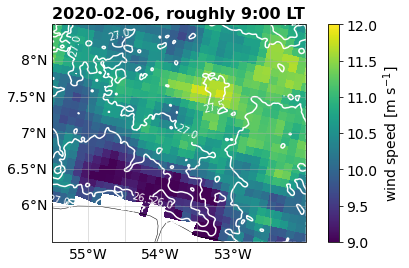

In [9]:
# Plot the map of wind speed and the SST contours.

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = ax.pcolormesh(lon_wind,lat_wind,wind_speed,vmin=9.,vmax=12.)
cs = ax.contour(sst_mur_lon,sst_mur_lat,sst_mur,np.arange(10,40,0.5),colors='w')
plt.clabel(cs)

cbar = plt.colorbar(pc,ax=ax)#,location='bottom',shrink=0.75)
cbar.set_label('wind speed [m s$^{-1}$]', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# This is to read the time of flight.
#i0, j0 = 1500, 50
#plt.plot(lon_wind[i0,j0],lat_wind[i0,j0],'xr')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.tick_params(axis='both',which='major',labelsize=14)

plt.title('2020-02-06, roughly 9:00 LT',fontsize=16,fontweight='bold')

figure_name = 'fig_ascat_wind.png'
plt.savefig(figure_name,bbox_inches='tight')

In [10]:
def crop_field(field,lon,lat,area):
    """
    Function to crop a 2d field over the area specified by the list
    area = [minlon,maxlon,minlat,maxlat]
    """
    valid_indices = np.argwhere((lon>area[0])&(lon<area[1])&(lat>area[2])&(lat<area[3]))
    x_min, y_min = valid_indices.min(axis=0)
    x_max, y_max = valid_indices.max(axis=0)
    return field[x_min:x_max+1, y_min:y_max+1]

<ipython-input-17-c60921975e4e>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon_ws_crop,lat_ws_crop,sst_interp) #,lat_ws_crop,ws_crop,vmin=9,vmax=12)


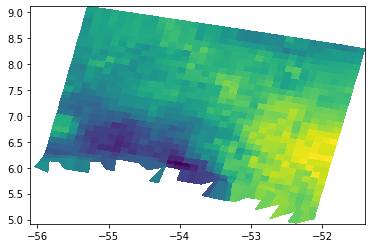

In [17]:
# Crop the MUR SST on the area shown in the figure.
llon, llat = np.meshgrid(sst_mur_lon,sst_mur_lat)
sst_crop = crop_field(sst_mur,llon,llat,extent_param)
lon_sst_crop = crop_field(llon,llon,llat,extent_param)
lat_sst_crop = crop_field(llat,llon,llat,extent_param)

# Crop the wind speed in the area shown in the figure.
ws_crop = crop_field(wind_speed,lon_wind,lat_wind,extent_param)
lon_ws_crop = crop_field(lon_wind,lon_wind,lat_wind,extent_param)
lat_ws_crop = crop_field(lat_wind,lon_wind,lat_wind,extent_param)

# Interpolate the cropped MUR SST grid on the ascat grid using the nearest neighbour.
from scipy.interpolate import griddata
sst_interp = griddata((lon_sst_crop.flatten(),lat_sst_crop.flatten()),sst_crop.flatten(),(lon_ws_crop,lat_ws_crop),
                     method='nearest')
sst_interp = sst_interp*ws_crop/ws_crop

plt.pcolor(lon_ws_crop,lat_ws_crop,sst_interp) #,lat_ws_crop,ws_crop,vmin=9,vmax=12)
#plt.contour(lon_sst_crop,lat_sst_crop,sst_crop,np.arange(10,40,0.5),colors='w')

/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


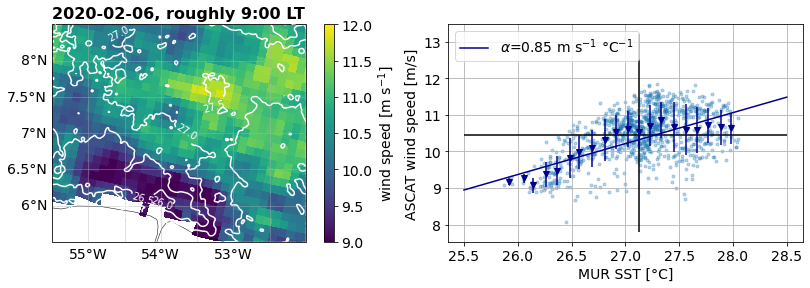

In [48]:
# Scatterplot.
a, b = sst_interp[~np.isnan(sst_interp)&~np.isnan(ws_crop)], ws_crop[~np.isnan(sst_interp)&~np.isnan(ws_crop)]

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 2, 1, projection=crs)
plot_background(ax)
pc = ax.pcolormesh(lon_wind,lat_wind,wind_speed,vmin=9.,vmax=12.)
cs = ax.contour(sst_mur_lon,sst_mur_lat,sst_mur,np.arange(10,40,0.5),colors='w')
plt.clabel(cs)

cbar = plt.colorbar(pc,ax=ax)#,location='bottom',shrink=0.75)
cbar.set_label('wind speed [m s$^{-1}$]', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# This is to read the time of flight.
#i0, j0 = 1500, 50
#plt.plot(lon_wind[i0,j0],lat_wind[i0,j0],'xr')

ax.set_xlabel('Longitude',fontsize=14)
ax.set_ylabel('Latitude',fontsize=14)
ax.tick_params(axis='both',which='major',labelsize=14)

ax.set_title('2020-02-06, roughly 9:00 LT',fontsize=16,fontweight='bold')

ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(a,b,marker='.',alpha=0.3)
plt.grid()
a_mean = np.nanmean(a)
b_mean = np.nanmean(b)
minx = 25.5
maxx = 28.5
ax1.hlines(b_mean,minx,maxx,'k')
miny = 7.8
maxy = 13.2
ax1.vlines(a_mean,miny,maxy,'k')
ax1.tick_params(axis='both',which='major',labelsize=14)
ax1.set_xlabel('MUR SST [°C]',fontsize=14)
ax1.set_ylabel('ASCAT wind speed [m/s]',fontsize=14)

slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope = metrics_fixed_bin_distribution(a,b)
ax1.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb,fmt='v',color='darkblue')
ax1.plot(np.array([minx,maxx]),np.array([minx,maxx])*slope+intercept,'darkblue',
         label='$\\alpha$='+"{:3.2f}".format(slope)+' m s$^{-1}$ °C$^{-1}$')
ax1.legend(fontsize=14,loc='upper left')

figure_name = 'fig_ascat_wind_and_scatter.png'
plt.savefig(figure_name,bbox_inches='tight')

In [ ]:
# I want to determine at what time the satellite is passing by.

plt.pcolormesh(lon_wind,lat_wind,wind_speed)
print(wind_speed.shape)
i0, j0 = 1500, 50
plt.plot(lon_wind[i0,j0],lat_wind[i0,j0],'xr')
print(lon_wind[i0,j0])
print(lat_wind[i0,j0])

print(ds_wind_newlon.time[i0,j0].values)

In [ ]:
# At this lingitude we are 3.66 hours behind, thus, 3 hours and 36 minutes, roughly.
55/360*24

In [ ]:
# As the UTC time of local pass is 2020-02-06T12:46:52.000000000, we can say that it is roughly 9:00 AM local time.